In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import glob
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
datadir='data/'

north_str = '300S'
dset1 = '_southof%s_swmt_'%north_str
lstr = 'sigma2'
#dl = '005'
dl = 'lores'

dset2 = '_moc_rho2_online_lores'
dset3 = '_dVdt_rho2_online_lores'

exp = 'control'

In [4]:
ddict = {mod:{} for mod in ['CM4','ESM4']}
for mod in ddict:
    for var in ['swmt','psi','Storage change']:
        if var == 'swmt':
            files = glob.glob(datadir+'%s_%s'%(mod,exp)+'_so_*'+dset1+'%s_%s.nc'%(lstr,dl))
        elif var == 'psi':
            files = glob.glob(datadir+'%s_%s_global_*'%(mod,exp)+dset2+'.nc')
        elif var == 'Storage change':
            files = glob.glob(datadir+'%s_%s_so_*'%(mod,exp)+dset3+'.nc')
            
        if len(files)>1:
            print('WARNING: More than one file for '+var+' in '+mod+'-'+exp+'. Please specify.')
        elif len(files)==0:
            print('ERROR: No file available for '+var+' in '+mod+'-'+exp)
            ddict[mod]['dVdt' if var =='Storage change' else var] = []
            continue
            
        print('Loading '+files[0])
        ddict[mod]['dVdt' if var =='Storage change' else var] = \
                        xr.open_dataset(files[0])[var].sel(time=slice(None,'0395'))

Loading data/CM4_control_so_0251to0395_southof300S_swmt_sigma2_lores.nc
Loading data/CM4_control_global_0251to0405_moc_rho2_online_lores.nc
Loading data/CM4_control_so_0251to0405_dVdt_rho2_online_lores.nc
Loading data/ESM4_control_so_0101to0270_southof300S_swmt_sigma2_lores.nc
Loading data/ESM4_control_global_0101to0270_moc_rho2_online_lores.nc
Loading data/ESM4_control_so_0101to0300_dVdt_rho2_online_lores.nc


In [5]:
tsdict = {mod:{} for mod in list(ddict.keys())}

for mod in tsdict:
    smoc = ddict[mod]['psi'].sel(rho2_i=slice(1020,None),yq=slice(None,0))                
    smoc['sigma2'] = smoc.rho2_i-1000
    smoc = smoc.swap_dims({'rho2_i':'sigma2'})
    psi = (-smoc).sel(yq=[-30], method='nearest').squeeze()
    
    dVdt = ddict[mod]['dVdt'].sel(rho2_i=slice(1020,None)) #1033,1038
    dVdt['sigma2'] = dVdt.rho2_i-1000
    dVdt = dVdt.swap_dims({'rho2_i':'sigma2'})
    
    G = ddict[mod]['swmt']*1e-6
    G_interp = G.interp(sigma2=psi.sigma2,kwargs={'fill_value':0}).groupby('time.year').mean('time')
    G_interp = G_interp.rename({'year':'time'}).assign_coords({'time': psi['time']})
    D = dVdt + psi - G_interp
    
    tsdict[mod]['psi'] = psi
    tsdict[mod]['swmt'] = G_interp
    tsdict[mod]['iwmt'] = D
    tsdict[mod]['dVdt'] = dVdt

In [6]:
ddict_wm = {mod:{} for mod in ['CM4','ESM4']}
ddict_wm['CM4']['water_mass'] = ['TW','SAMW','AAIW','CDW','AABW']
ddict_wm['CM4']['sig2'] = [35.60, 36.10, 36.60, 37.06]
ddict_wm['ESM4']['water_mass'] = ['TW','SAMW','AAIW','CDW','AABW']
ddict_wm['ESM4']['sig2'] = [35.20, 35.60, 36.50, 37.03]

In [7]:
subdir = 'ESM4_piControl_D'
rho2_i = xr.open_dataset(datadir+subdir+'_volcello_rho2_lores.nc').rho2_i.sel(rho2_i=slice(1020,None)).values
rho2_l = xr.open_dataset(datadir+subdir+'_volcello_rho2_lores.nc').rho2_l.sel(rho2_l=slice(1020,None)).values

In [8]:
tctr_cm4 = ['0281', '0380']
tctr_esm4 = ['0121', '0220']

In [9]:
for i, mod in enumerate(tsdict):
    print('\n'+mod)
    ti = tctr_cm4[0] if mod=='CM4' else tctr_esm4[0]
    tf = tctr_cm4[1] if mod=='CM4' else tctr_esm4[1]
    for var in tsdict[mod]:
        print(var)
        y = tsdict[mod][var].sel(time=slice(ti,tf))
        
        dy = -1.*y.diff('sigma2',label='lower')
        dy['sigma2'] = rho2_l-1000
        
        das = []
        for widx, wm in enumerate(ddict_wm[mod]['water_mass']):
            if widx ==0:
                print('Sum above',ddict_wm[mod]['sig2'][widx])
                das.append(dy[:,dy.sigma2<ddict_wm[mod]['sig2'][widx]].sum(dim='sigma2'))
            elif widx < (len(ddict_wm[mod]['water_mass'])-1):
                print('Sum between',ddict_wm[mod]['sig2'][widx-1],'and',ddict_wm[mod]['sig2'][widx])
                das.append(dy[:,(dy.sigma2>=ddict_wm[mod]['sig2'][widx-1])\
                              &(dy.sigma2<ddict_wm[mod]['sig2'][widx])].sum(dim='sigma2'))
            else:
                print('Sum below',ddict_wm[mod]['sig2'][widx-1])
                das.append(dy[:,dy.sigma2>=ddict_wm[mod]['sig2'][widx-1]].sum(dim='sigma2'))
                
        da = xr.concat(das,pd.Index(ddict_wm[mod]['water_mass'], name='water_mass'))       
        ddict_wm[mod][var] = da.reset_coords(drop=True)


CM4
psi
Sum above 35.6
Sum between 35.6 and 36.1
Sum between 36.1 and 36.6
Sum between 36.6 and 37.06
Sum below 37.06
swmt
Sum above 35.6
Sum between 35.6 and 36.1
Sum between 36.1 and 36.6
Sum between 36.6 and 37.06
Sum below 37.06
iwmt
Sum above 35.6
Sum between 35.6 and 36.1
Sum between 36.1 and 36.6
Sum between 36.6 and 37.06
Sum below 37.06
dVdt
Sum above 35.6
Sum between 35.6 and 36.1
Sum between 36.1 and 36.6
Sum between 36.6 and 37.06
Sum below 37.06

ESM4
psi
Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03
swmt
Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03
iwmt
Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03
dVdt
Sum above 35.2
Sum between 35.2 and 35.6
Sum between 35.6 and 36.5
Sum between 36.5 and 37.03
Sum below 37.03


### Table 1

In [15]:
mod = 'CM4'
wm = 'AABW'

print(np.round(ddict_wm[mod]['psi'].sel(water_mass=wm).mean('time').values,1))
print(np.round(ddict_wm[mod]['psi'].sel(water_mass=wm).std('time').values,1))

7.5
1.9


**Table 1**: Circumpolar mean density ranges in $\sigma_2$, volume transports at 30\oS, surface and interior formation south of at 30\oS for key Southern Ocean water masses in CM4 and ESM4: thermocline water (TW), Subantarctic Mode Water (SAMW), Antarctic Intermediate Water (AAIW), Circumpolar Deep Water (CDW) and Antarctic Bottom Water (AABW). Note that in the circumpolar mean, North Atlantic Deep Water (NADW) is considered part of the CDW. Note that the uncertainties in transports and formation are presented as $\pm$ 1 standard deviations derived from the annual means over the given 100-year time periods.

### Transport by basin

In [18]:
ddict_df = {var:{} for var in ['CM4','ESM4']}
ddict_df['CM4'] = pd.read_csv(datadir+'CM4_control_so_0281to0380_at30S_mvt_rho2_basins.csv',index_col='rho2_l')
ddict_df['ESM4'] = pd.read_csv(datadir+'ESM4_control_so_0121to0220_at30S_mvt_rho2_basins.csv',index_col='rho2_l')

In [19]:
ddict_basin = {b:{} for b in ['Atlantic','Pacific','Indian']}
ddict_basin['Atlantic']['water_mass'] = ['TW','SAMW','AAIW','NADW','AABW']
ddict_basin['Pacific']['water_mass'] = ['TW','SAMW','AAIW','CDW','AABW']
ddict_basin['Indian']['water_mass'] = ['TW','SAMW','AAIW','CDW','AABW']

ddict = {var:{} for var in ['CM4','ESM4']}
for mod in ddict:
    ddict[mod] = {b:{} for b in list(ddict_basin.keys())}
    for name in ddict[mod]:
        ddict[mod][name]['water_mass'] = ddict_basin[name]['water_mass']
        
ddict['CM4']['Atlantic']['sig2'] = [35.3,35.9,36.55,37.08]
ddict['CM4']['Pacific']['sig2'] = [35.8, 36.2, 36.6, 37.05]
ddict['CM4']['Indian']['sig2'] = [35.7, 36.2, 36.6, 37.065]
ddict['ESM4']['Atlantic']['sig2'] = [35.2,35.4,36.55,37.08]
ddict['ESM4']['Pacific']['sig2'] = [35.3, 35.65, 36.45, 37.01]
ddict['ESM4']['Indian']['sig2'] = [35.2, 35.7, 36.6, 37.01]

for mod in ddict:
    df = ddict_df[mod]
    for idx, (name, values) in enumerate(df.iteritems()):    
        vtrsp = []
        for widx, wm in enumerate(ddict[mod][name]['water_mass']):
            if widx ==0:
                vtrsp.append(df[df.index<ddict[mod][name]['sig2'][widx]+1000][name].sum())
            elif widx < (len(ddict[mod][name]['water_mass'])-1):
                vtrsp.append(df[(df.index>=ddict[mod][name]['sig2'][widx-1]+1000)\
                                &(df.index<ddict[mod][name]['sig2'][widx]+1000)][name].sum())
            else:
                vtrsp.append(df[df.index>=ddict[mod][name]['sig2'][widx-1]+1000][name].sum())      
        ddict[mod][name]['vol_trsp'] = vtrsp

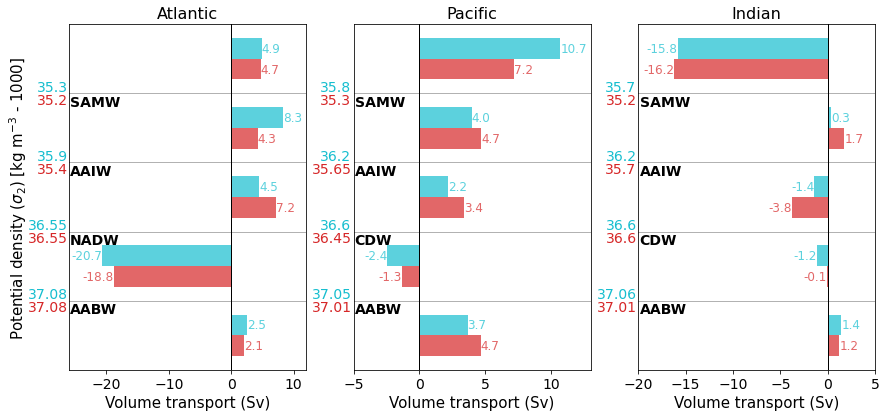

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.2)

cstr = ['tab:cyan','tab:red']

for idx, name in enumerate(ddict_basin):
    
    axs[idx].axvline(x=0, c = 'k', ls='-', lw=1)
    
    y = np.arange(len(ddict_basin[name]['water_mass'])) + 0.5
    yloc = y
    
    p = []
    for m, mod in enumerate(ddict):
        x = ddict[mod][name]['vol_trsp']
        p += axs[idx].barh(yloc-0.15 if mod=='CM4' else yloc+0.15, x, height=0.3 ,align='center',
                           color=cstr[m], alpha=0.7)
        
    for i, bar in enumerate(p):
        val = bar.get_width()
        axs[idx].text(bar.get_width(), bar.get_y() + bar.get_height() / 2.0 , 
                      f'{val:.1f}', ha='right' if val<0 else 'left', va='center',fontsize=12,
                      color=bar.get_facecolor())
        
    # Add subtitles and adjust xlimit
    if name=='Atlantic':
        axs[idx].set_title('Atlantic',fontsize=16)
        axs[idx].set_xlim([-26,12])
    elif name=='Pacific':
        axs[idx].set_title('Pacific',fontsize=16)
        axs[idx].set_xlim([-5,13])
    elif name=='Indian':
        axs[idx].set_title('Indian',fontsize=16)
        axs[idx].set_xlim([-20,5])
    
    # Add water mass names
    xlimit = axs[idx].get_xlim()
    for i, yline in enumerate(y[1:]-0.5):
        axs[idx].text(xlimit[0]+abs(xlimit[1]+xlimit[0])/100, yline+0.02, ddict_basin[name]['water_mass'][i+1], 
                      fontsize=14, fontweight='bold',ha='left', va='top')
        
    axs[idx].grid(True, 'major', 'y', ls='-', lw=1, c='k', alpha=.3)
    axs[idx].tick_params(axis='both', which='both', labelsize=14,
                         bottom=True, top=False, labelbottom=True,
                         left=False, right=False, labelleft=False)

    axs[idx].set_ylim((0,5))
    axs[idx].set_yticks(y[1:]-0.5)
    #axs[idx].set_yticklabels([f'{val:.1f}' for val in ddict[mod][name]['sig2']])
    axs[idx].tick_params(axis='y', which='major', pad=0)
    
    for m, mod in enumerate(ddict):
        for i, yline in enumerate(y[1:]-0.5):
            if mod=='CM4':
                axs[idx].text(xlimit[0]-0.15,yline-0.09,np.round(ddict[mod][name]['sig2'][i],2),
                              color='tab:cyan',fontsize=14,ha='right', va='center')
            elif mod=='ESM4':
                axs[idx].text(xlimit[0]-0.15,yline+0.09,np.round(ddict[mod][name]['sig2'][i],2),
                              color='tab:red',fontsize=14,ha='right', va='center')
    
    axs[idx].invert_yaxis()
    axs[idx].set_xlabel('Volume transport (Sv)',fontsize=15)
    axs[0].set_ylabel(r'Potential density ($\sigma_2$) [kg m$^{-3}$ - 1000]',fontsize=15,labelpad=40)
plt.show()